### Libraries

In [15]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib.animation import FuncAnimation 
from mpl_toolkits.mplot3d import Axes3D
import time
import copy

### Config

In [6]:
TRAIN_NPZ = "/Users/akhidre/pubgit/HumanML3D/HumanML3D/paired_text_motion.npz"
TEST_NPZ  = "/Users/akhidre/pubgit/HumanML3D/HumanML3D/paired_text_motion_val.npz"
NORM_STATS = "motion_norm_stats.npz"   # if exists, used; otherwise computed from train npz

MOTION_LEN = 200         # fixed length for MLP outputs (frames)
NUM_JOINTS = 22
COORDS = 3
OUTPUT_DIM = MOTION_LEN * NUM_JOINTS * COORDS

MAX_TRAIN_SAMPLES = 500    # 0 = use all; otherwise use first N pairs
MAX_TEST_SAMPLES = 50     # 0 = use all; otherwise use first N pairs

# Training hyperparams
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 1e-4
HIDDEN_DIMS = [1024, 2048, 8192]  # list: number of neurons per hidden Dense layer

# Loss options
USE_VELOCITY_LOSS = False
LAMBDA_VEL = 0.1
USE_WEIGHT_DECAY = True
WEIGHT_DECAY = 1e-4

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

### Utilities Functions

In [7]:
def load_npz_pairs(npz_path, max_samples=0):
    data = np.load(npz_path, allow_pickle=True)
    z_texts = data["z_texts"]   # shape (N, 384)
    motions = data["motions"]   # dtype=object, each entry (T, J, 3)
    motion_ids = data["motion_ids"] if "motion_ids" in data.files else None

    if max_samples and max_samples > 0:
        z_texts = z_texts[:max_samples]
        motions = motions[:max_samples]
        if motion_ids is not None:
            motion_ids = motion_ids[:max_samples]

    return z_texts, motions, motion_ids

def compute_mean_std_from_train_motions(motions, save_path=None):
    """
    Compute per-coordinate mean and std for a list of motion sequences.

    Args:
        motions: list or object array of motions, each shape (T, J, 3)
        save_path: str or None, optional path to save stats as .npz

    Returns:
        mean: np.array of shape (3,)
        std: np.array of shape (3,)
    """
    coords_list = []
    for m in motions:
        coords_list.append(m.reshape(-1, 3))
    all_coords = np.concatenate(coords_list, axis=0)
    mean = np.mean(all_coords, axis=0).astype(np.float32)
    std  = np.std(all_coords, axis=0).astype(np.float32) + 1e-8

    if save_path is not None:
        np.savez(save_path, mean=mean, std=std)
        print(f"Saved motion normalization stats to {save_path}")
    return mean.astype(np.float32), std.astype(np.float32)

def pad_or_truncate_motion(motion, target_len=MOTION_LEN):
    T, J, C = motion.shape
    if T == target_len:
        return motion.astype(np.float32)
    if T > target_len:
        return motion[:target_len].astype(np.float32)
    # T < target_len: pad with zeros at end
    pad_len = target_len - T
    last_frame = motion[-1][None, :, :]  # shape (1, J, C)
    pad = np.repeat(last_frame, pad_len, axis=0)  # repeat last frame
    return np.concatenate([motion.astype(np.float32), pad], axis=0)

def normalize_motion(motion, mean, std):
    # motion: (T, J, 3) -> broadcast mean/std over joints/frames
    return (motion - mean) / std

def denormalize_motion(motion_norm, mean, std):
    return motion_norm * std + mean

### Load data 

In [8]:
print("Loading train npz:", TRAIN_NPZ)
z_train, motions_train, ids_train = load_npz_pairs(TRAIN_NPZ, max_samples=MAX_TRAIN_SAMPLES)
print("Loading test npz:", TEST_NPZ)
z_test, motions_test, ids_test = load_npz_pairs(TEST_NPZ, max_samples=MAX_TEST_SAMPLES)

print("Train captions:", z_train.shape)
print("Train motions count:", len(motions_train))
print("Test captions:", z_test.shape)
print("Test motions count:", len(motions_test))

Loading train npz: /Users/akhidre/pubgit/HumanML3D/HumanML3D/paired_text_motion.npz
Loading test npz: /Users/akhidre/pubgit/HumanML3D/HumanML3D/paired_text_motion_val.npz
Train captions: (500, 384)
Train motions count: 500
Test captions: (50, 384)
Test motions count: 50


### Compute data statistics

In [9]:
if os.path.exists(NORM_STATS):
    stats = np.load(NORM_STATS)
    mean = stats["mean"]   # shape (3,)
    std = stats["std"]
    print("Loaded normalization stats from", NORM_STATS, "mean:", mean, "std:", std)
else:
    print("Computing normalization stats from training motions...")
    # compute and save in one call
    mean, std = compute_mean_std_from_train_motions(motions_train, save_path=NORM_STATS)
print()

Computing normalization stats from training motions...
Saved motion normalization stats to motion_norm_stats.npz



### Prepare dataset

In [10]:
def prepare_xy(z_list, motions_objectlist, mean, std, motion_len=MOTION_LEN):
    N = len(z_list)
    X = np.array(z_list, dtype=np.float32)   # (N, 384)
    Y = np.zeros((N, motion_len, NUM_JOINTS, COORDS), dtype=np.float32)
    for i, m in enumerate(motions_objectlist):
        m_fixed = pad_or_truncate_motion(m, target_len=motion_len)
        m_norm = normalize_motion(m_fixed, mean, std)
        Y[i] = m_norm
    # flatten Y for MLP regression target
    Y_flat = Y.reshape(N, -1).astype(np.float32)
    return X, Y_flat, Y  # also return 3D Y if needed

print("Preparing training tensors...")
X_train, Y_train_flat, Y_train_3d = prepare_xy(z_train, motions_train, mean, std)
print("Preparing test tensors...")
X_test, Y_test_flat, Y_test_3d = prepare_xy(z_test, motions_test, mean, std)

print("Shapes -> X_train:", X_train.shape, "Y_train_flat:", Y_train_flat.shape)
print("Shapes -> X_test :", X_test.shape, "Y_test_flat :", Y_test_flat.shape)

Preparing training tensors...
Preparing test tensors...
Shapes -> X_train: (500, 384) Y_train_flat: (500, 13200)
Shapes -> X_test : (50, 384) Y_test_flat : (50, 13200)


MLP Model

In [11]:
tf.keras.backend.clear_session()
inputs = tf.keras.Input(shape=(X_train.shape[1],), dtype=tf.float32, name="z_text")

x = inputs
for i, h in enumerate(HIDDEN_DIMS):
    x = tf.keras.layers.Dense(h, activation="relu", name=f"dense_{i+1}")(x)
# final linear layer -> output_dim
outputs_flat = tf.keras.layers.Dense(OUTPUT_DIM, activation=None, name="output_flat")(x)

# Optionally reshape inside model (but we will train with flattened y)
# outputs_reshaped = tf.keras.layers.Reshape((MOTION_LEN, NUM_JOINTS, COORDS))(outputs_flat)

model = tf.keras.Model(inputs=inputs, outputs=outputs_flat, name="MLP_Motion_Decoder")
model.summary()

# ---------------------------
# Loss: MSE + optional velocity loss + optional weight decay
# ---------------------------
def velocity_loss_from_flat(y_true_flat, y_pred_flat, motion_len=MOTION_LEN):
    # y_true_flat, y_pred_flat: (batch, motion_len * J * C)
    # reshape
    batch = tf.shape(y_true_flat)[0]
    y_true = tf.reshape(y_true_flat, (batch, motion_len, NUM_JOINTS, COORDS))
    y_pred = tf.reshape(y_pred_flat, (batch, motion_len, NUM_JOINTS, COORDS))
    # velocities: difference over time axis
    v_true = y_true[:,1:] - y_true[:,:-1]
    v_pred = y_pred[:,1:] - y_pred[:,:-1]
    return tf.reduce_mean(tf.square(v_pred - v_true))

# Custom training step via compile with custom loss wrapper
def custom_loss(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_pred - y_true))
    if USE_VELOCITY_LOSS:
        vel = velocity_loss_from_flat(y_true, y_pred)
        loss_val = mse + LAMBDA_VEL * vel
    else:
        loss_val = mse
    # weight decay: implemented via add_loss on kernel weights (or via optimizer weight decay)
    if USE_WEIGHT_DECAY and WEIGHT_DECAY > 0:
        wd = tf.add_n([tf.nn.l2_loss(v) for v in model.trainable_weights])
        loss_val = loss_val + WEIGHT_DECAY * wd
    return loss_val

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer, loss=custom_loss, metrics=["mse"])

Model: "MLP_Motion_Decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ z_text (InputLayer)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2048)           │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8192)           │    16,785,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_flat (Dense)             │ (None, 13200)          │   108,147,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 127,426,448 (486.09 MB)

 Trainable params: 127,426,448 (486.09 MB)

 Non-trainable params: 0 (0.00 B)

### Training

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 245ms/step - loss: 1.9817 - mse: 1.2503 - val_loss: 1.5165 - val_mse: 0.8306
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 229ms/step - loss: 1.6948 - mse: 1.0434 - val_loss: 1.2635 - val_mse: 0.6512
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 226ms/step - loss: 1.5154 - mse: 0.9345 - val_loss: 1.1775 - val_mse: 0.6318
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 227ms/step - loss: 1.4386 - mse: 0.9202 - val_loss: 1.1152 - val_mse: 0.6282
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 230ms/step - loss: 1.3515 - mse: 0.8873 - val_loss: 1.0112 - val_mse: 0.5727
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 228ms/step - loss: 1.2215 - mse: 0.8008 - val_loss: 0.9294 - val_mse: 0.5293
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 244ms/step - loss: 1.1228 - mse: 0.7391 - val_loss: 0.8467 - val_mse: 0.4819
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - loss: 1.0496 - mse: 0.6983 - val_loss: 0.7947 - val_mse: 0.4585
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 225ms/step - lo

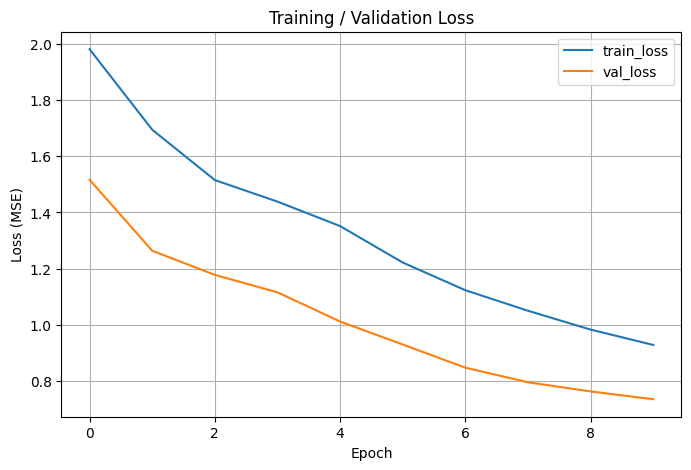

In [12]:
history = model.fit(
    X_train, Y_train_flat,
    validation_data=(X_test, Y_test_flat),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True
)

# plot loss curves
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Training / Validation Loss')
plt.grid(True)
plt.show()


### Testing

In [13]:
test_metrics = model.evaluate(X_test, Y_test_flat, batch_size=BATCH_SIZE, return_dict=True)
print("Test metrics:", test_metrics)

# compute velocity loss separately if needed
if USE_VELOCITY_LOSS:
    preds_flat = model.predict(X_test, batch_size=BATCH_SIZE)
    vel_loss_val = velocity_loss_from_flat(tf.constant(Y_test_flat), tf.constant(preds_flat))
    print("Test velocity loss:", float(vel_loss_val))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.7344 - mse: 0.4428 
Test metrics: {'loss': 0.7343618273735046, 'mse': 0.4427725076675415}


## Run Example

In [ ]:
sample_idx = 0 #first test file #004822.txt
z = X_test[sample_idx:sample_idx+1]
pred_flat = model.predict(z)  # shape (1, OUTPUT_DIM)
pred_3d = pred_flat.reshape(MOTION_LEN, NUM_JOINTS, COORDS)
pred_real = denormalize_motion(pred_3d, mean, std)

print("Predicted motion (first sample) denormalized shape:", pred_real.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
Predicted motion (first sample) denormalized shape: (200, 22, 3)


### Animation 

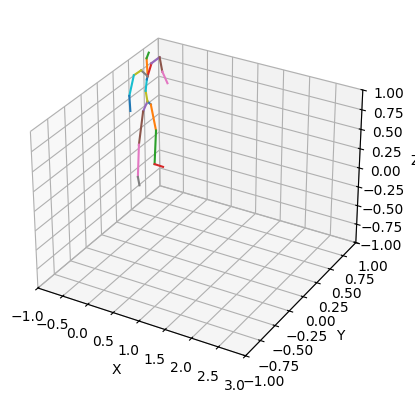

In [17]:
pose=copy.deepcopy(pred_real)
#SMPL 22-joint skeleton
edges = [
    (0, 1), (1, 4), (4, 7), (7, 10),
    (0, 2), (2, 5), (5, 8), (8, 11),
    (0, 3), (3, 6), (6, 9), (9, 12), (12, 15),
    (9, 13), (13, 16), (16, 18), (18, 20),
    (9, 14), (14, 17), (17, 19), (19, 21),
]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Create lines initially without data
lines = [ax.plot([], [], [])[0] for _ in range(pose.shape[1] - 1)]
ax.set(xlim3d=(-1, 3), xlabel='X')
ax.set(ylim3d=(-1, 1), ylabel='Y')
ax.set(zlim3d=(-1, 1), zlabel='Z')

def init(): 
    ax.cla()
    return ax,

def update_lines(frame_num, pose, lines):
    frame = pose[frame_num]
    for n in range(len(lines)):
        i, j = edges[n]
        x = [frame[i, 0], frame[j, 0]]
        y = [frame[i, 1], frame[j, 1]]
        z = [frame[i, 2], frame[j, 2]]
        lines[n].set_data_3d([z,x,y])
    return lines

ani = FuncAnimation(
    fig, update_lines, pose.shape[0], fargs=(pose, lines), interval=100)
ani.save('/Users/akhidre/pubgit/HumanML3D/HumanML3D/animations/generate_004822.mp4', 
          writer = 'ffmpeg', fps = 30)

Troubleshoot/Debug

In [24]:
print(motions_test[0].shape)
print(Y_test_3d[0].shape)

(193, 22, 3)
(200, 22, 3)
